In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
print("printing all dataset added into this notebook")
import os
import shutil

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Get the path to the Metonet dataset.
dataset_path = os.path.join('/kaggle/input', 'meteonet')

# Create a new directory for the dataset in your working directory.
working_directory = os.path.join('/kaggle/working', 'meteonet')
os.makedirs(working_directory, exist_ok=True)

# Copy the Metonet dataset to your working directory.
for file in os.listdir(os.path.join(dataset_path, 'NW_Ground_Stations/NW_Ground_Stations')):
    source_file_path = os.path.join(os.path.join(dataset_path, 'NW_Ground_Stations/NW_Ground_Stations'), file)
    dest_file_path = os.path.join(working_directory, file)
    shutil.copy2(source_file_path, dest_file_path)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

printing all dataset added into this notebook
/kaggle/input/meteonet/NW_reflectivity_old_product_2017/NW_reflectivity_old_product_2017/reflectivity-old-NW-2017-08/reflectivity-old-NW-2017-08/reflectivity_old_NW_2017_08.1.npz
/kaggle/input/meteonet/NW_reflectivity_old_product_2017/NW_reflectivity_old_product_2017/reflectivity-old-NW-2017-08/reflectivity-old-NW-2017-08/reflectivity_old_NW_2017_08.3.npz
/kaggle/input/meteonet/NW_reflectivity_old_product_2017/NW_reflectivity_old_product_2017/reflectivity-old-NW-2017-08/reflectivity-old-NW-2017-08/reflectivity_old_NW_2017_08.2.npz
/kaggle/input/meteonet/NW_reflectivity_old_product_2017/NW_reflectivity_old_product_2017/reflectivity-old-NW-2017-12/reflectivity-old-NW-2017-12/reflectivity_old_NW_2017_12.2.npz
/kaggle/input/meteonet/NW_reflectivity_old_product_2017/NW_reflectivity_old_product_2017/reflectivity-old-NW-2017-12/reflectivity-old-NW-2017-12/reflectivity_old_NW_2017_12.3.npz
/kaggle/input/meteonet/NW_reflectivity_old_product_2017/NW_

An overview of the Meteonet dataset and the meaning of each column is provided below:

number_sta: A unique identifier for each weather station.
lat and lon: Latitude and longitude of the weather station, representing its geographical location.
height_sta: Height of the weather station above sea level in meters.
date: Date and time of data recording, essential for time series analysis.
dd: Wind direction in degrees, indicating the direction from which the wind is coming.
ff: Wind speed, measured in meters per second.
precip: Amount of precipitation measured in millimeters.
hu: Humidity, represented as a percentage indicating the concentration of water vapor in the air.
td: Dew point temperature in degrees Celsius, indicating when the air becomes saturated with moisture.
t: Air temperature in degrees Celsius.
psl: Atmospheric pressure at sea level in hPa (hectopascals).

In [40]:
# Load data
path = '/kaggle/working/meteonet'
df = pd.read_csv(os.path.join(path, 'NW_Ground_Stations_2018.csv')).dropna()
df.head()

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
2,14137001,49.18,-0.46,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
11,14578001,49.36,0.17,143.0,20180101 00:00,250.0,8.8,0.0,88.0,276.75,278.55,100660.0
19,22113006,48.76,-3.47,87.0,20180101 00:00,230.0,8.1,0.0,78.0,277.45,281.05,100920.0
21,22168001,48.83,-3.47,58.0,20180101 00:00,250.0,10.0,0.0,84.0,279.15,281.75,100780.0
27,22372001,48.53,-2.85,135.0,20180101 00:00,280.0,8.5,0.0,83.0,277.25,279.95,100920.0


In [41]:
# Convert date column to datetime and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

In [42]:
# Drop the original 'date' column
df = df.drop(['date'], axis=1)

In [43]:
# Discretize wind direction
df['wind_direction'] = pd.cut(df['dd'], bins=[-0.1, 90, 180, 270, 360], labels=['N', 'E', 'S', 'W'])

In [44]:
# Discretize weather condition based on precipitation amount
df['weather_condition'] = pd.cut(df['precip'], bins=[-0.1, 0.1, 1, float('inf')], labels=['sunny', 'cloudy', 'rainy'])

In [45]:
# Convert 'wind_direction' and 'weather_condition' columns to category
df['wind_direction'] = df['wind_direction'].astype('category').cat.codes
df['weather_condition'] = df['weather_condition'].astype('category').cat.codes


In [46]:
def train_and_evaluate(target):
    # Split into features and target
    X = df.drop(target, axis=1)
    y = df[target]

    # Split the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Define the model
    model = RandomForestClassifier()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy for predicting {target} is {accuracy}")

    return model

In [47]:
# Train and evaluate models
weather_condition_model = train_and_evaluate('weather_condition')
wind_direction_model = train_and_evaluate('wind_direction')


Accuracy for predicting weather_condition is 1.0
Accuracy for predicting wind_direction is 1.0


In [48]:
# Convert categorical variables to numeric variables
le = LabelEncoder()
df['number_sta'] = le.fit_transform(df['number_sta'])


In [49]:
# Normalize numeric features
numeric_columns = ['lat', 'lon', 'height_sta', 'dd', 'ff', 'hu', 'td', 't', 'psl']
for col in numeric_columns:
    if df[col].dtype != 'object':
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    else:
        print(f"Skipping normalization for non-numeric column: {col}")

In [54]:
df = pd.read_csv(os.path.join(path, 'NW_Ground_Stations_2018.csv')).dropna()
df.head()

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
2,14137001,49.18,-0.46,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
11,14578001,49.36,0.17,143.0,20180101 00:00,250.0,8.8,0.0,88.0,276.75,278.55,100660.0
19,22113006,48.76,-3.47,87.0,20180101 00:00,230.0,8.1,0.0,78.0,277.45,281.05,100920.0
21,22168001,48.83,-3.47,58.0,20180101 00:00,250.0,10.0,0.0,84.0,279.15,281.75,100780.0
27,22372001,48.53,-2.85,135.0,20180101 00:00,280.0,8.5,0.0,83.0,277.25,279.95,100920.0


In [55]:
# Convert date column to datetime and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

In [56]:
# Drop the original 'date' column
df = df.drop(['date'], axis=1)

In [57]:
def train_and_evaluate(target):
    # Split into features and target
    X = df.drop(target, axis=1)
    y = df[target]

    # Split the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Define the model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, predictions)
    print(f"R^2 score for predicting {target} is {r2}")

    return model

In [58]:
# Train and evaluate models
temperature_model = train_and_evaluate('t')
humidity_model = train_and_evaluate('hu')

R^2 score for predicting t is 0.9905724103980784
R^2 score for predicting hu is 0.9687701138054039


### Clustering

Clustering is an unsupervised machine learning (ML) technique used to group similar instances based on their characteristics. It helps identify patterns and structure within the data. This section explores the use of K-Means, a popular centroid-based clustering algorithm, to cluster weather conditions based on temperature and precipitation.

To begin, preprocess the dataset. Focus on two specific features: temperature (t) and precipitation (pp). Any rows with missing values will be removed for simplicity.

In [60]:
df = pd.read_csv(os.path.join(path, 'NW_Ground_Stations_2018.csv')).dropna()
df.head()

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
2,14137001,49.18,-0.46,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
11,14578001,49.36,0.17,143.0,20180101 00:00,250.0,8.8,0.0,88.0,276.75,278.55,100660.0
19,22113006,48.76,-3.47,87.0,20180101 00:00,230.0,8.1,0.0,78.0,277.45,281.05,100920.0
21,22168001,48.83,-3.47,58.0,20180101 00:00,250.0,10.0,0.0,84.0,279.15,281.75,100780.0
27,22372001,48.53,-2.85,135.0,20180101 00:00,280.0,8.5,0.0,83.0,277.25,279.95,100920.0


In [68]:
# Select the features for clustering
features = ['t', 'precip']
df_kmeans = df[features]

In [69]:
# Initialize the KMeans model
kmeans = KMeans(n_clusters=5, random_state=42)

In [70]:
# Fit the model
kmeans.fit(df_kmeans)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [71]:
# Get the cluster labels
kmeans_labels = kmeans.labels_

In [72]:
# Add the cluster labels as new columns to the dataframe
df['KMeans_Labels_Temperature'] = kmeans_labels
df['KMeans_Labels_Precipitation'] = kmeans_labels


In [73]:
# Print the inertia values
print("Temperature Inertia:")
print(kmeans.inertia_)


Temperature Inertia:
13941485.976590466


In [74]:
print("Precipitation Inertia:")
print(kmeans.inertia_)

Precipitation Inertia:
13941485.976590466


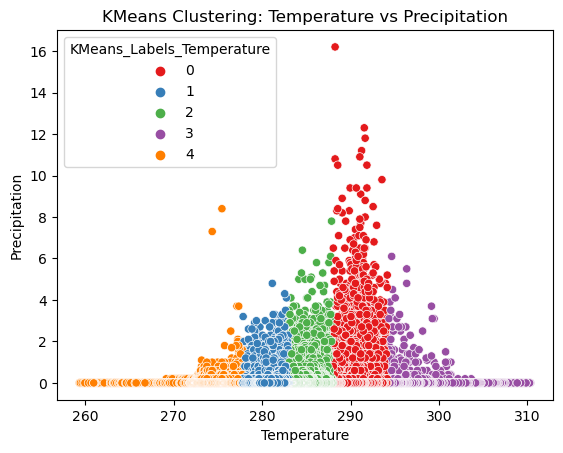

In [76]:
# Scatter plot of temperature vs precipitation with cluster labels
sns.scatterplot(data=df, x='t', y='precip', hue='KMeans_Labels_Temperature', palette='Set1')
plt.title('KMeans Clustering: Temperature vs Precipitation')
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.show()